## 第七章作业

#### 1. 在“LoRA 低秩适配 OpenAI Whisper-Large-V2 语音识别任务”中，为中文语料的训练过程增加过程评估，观察 Train Loss 和 Validation Loss 变化。课程代码（ https://github.com/DjangoPeng/LLM-quickstart/blob/main/peft/peft_lora_whisper-large-v2.ipynb ）

In [2]:
model_name = "openai/whisper-large-v2"
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
task = "transcribe"
dataset_name = "mozilla-foundation/common_voice_11_0"

batch_size = 64

In [3]:
from datasets import load_dataset, DatasetDict, Audio

common_voice = DatasetDict()
common_voice['train'] = load_dataset(dataset_name, language_abbr, split='train', trust_remote_code=True)
common_voice['validation'] = load_dataset(dataset_name, language_abbr, split='validation', trust_remote_code=True)

In [4]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, language=language, task=task)
processor = AutoProcessor.from_pretrained(model_name, language=language, task=task)

/root/venvs/py311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])
common_voice = common_voice.cast_column('audio', Audio(sampling_rate=16000))

In [6]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 29056
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 10581
    })
})

In [9]:
def prepare_dataset(batch):
    audio = batch['audio']
    batch['input_features'] = feature_extractor(audio['array'], sampling_rate=audio['sampling_rate']).input_features[0]
    batch['labels'] = tokenizer(batch['sentence']).input_ids
    return batch

In [8]:
small_common_voice = DatasetDict()
small_common_voice['train'] = common_voice['train']
small_common_voice['validation'] = common_voice['validation'].shuffle(seed=16).select(range(640))
tokenized_common_voice = small_common_voice.map(prepare_dataset)

Map:   0%|          | 0/29056 [00:00<?, ? examples/s]

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

In [14]:
# tokenized_common_voice = common_voice.map(prepare_dataset, num_proc=8)
# tokenized_common_voice = common_voice.map(prepare_dataset)

In [ ]:
from ch7_utils import prepare_dataset

# tokenized_common_voice_test = common_voice.map(prepare_dataset, num_proc=8)

In [13]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{'input_features': feature['input_features']} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors='pt')

        label_features = [{'input_ids': feature['labels']} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors='pt')

        labels = labels_batch['input_ids'].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]
        
        batch['labels'] = labels
        return batch

In [10]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [12]:
from transformers import AutoModelForSpeechSeq2Seq

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name, load_in_8bit=True, device_map='auto')
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [13]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/root/venvs/py311/lib/python3.11/site-packages/peft/utils/other.py:141: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=4,
    lora_alpha=64,
    target_modules=['q_proj', 'v_proj'],
    lora_dropout=0.05,
    bias='none'
)

In [15]:
peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,966,080 || all params: 1,545,271,040 || trainable%: 0.12723204856023188


In [16]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,
    overwrite_output_dir=True,
    per_device_train_batch_size=batch_size,
    learning_rate=1e-3,
    num_train_epochs=1,
    # evaluation_strategy='epoch',
    warmup_steps=50,
    fp16=True,
    per_device_eval_batch_size=batch_size,
    generation_max_length=128,
    logging_steps=10,
    remove_unused_columns=False,
    label_names=['labels'],
    evaluation_strategy='steps',
    eval_steps=25,
    save_steps=50,
    save_total_limit=2
)

In [17]:
from transformers import TrainerCallback

class LossCallback(TrainerCallback):
    def __init__(self) -> None:
        super().__init__()
        self.train_losses = []
        self.eval_losses = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append((state.global_step, logs['loss']))
        if 'eval_loss' in logs:
            self.eval_losses.append((state.global_step, logs['eval_loss']))

loss_callback = LossCallback()

In [18]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=peft_model,
    train_dataset=tokenized_common_voice['train'],
    eval_dataset=tokenized_common_voice['validation'],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor
)
peft_model.config.use_cache = False

trainer.add_callback(loss_callback)

In [19]:
import json

# trainer.train()
trainer.train(resume_from_checkpoint=True)

steps_losses = [loss_callback.train_losses, loss_callback.eval_losses]
losses_filename = 'ch7.steps_losses.json'
with open(losses_filename, 'w', encoding='utf-8') as fp:
    json.dump(steps_losses, fp)

Step,Training Loss,Validation Loss
25,1.637900,1.153170
50,1.782800,0.618904
75,0.512700,0.491825
100,0.387000,0.472729
125,0.379700,0.458357
150,0.334200,0.445311
175,0.403300,0.435924
200,0.396600,0.436175
225,0.343800,0.427144
250,0.385900,0.423188


In [22]:
trainer.save_model(model_dir)

#### 绘制损失值变化图

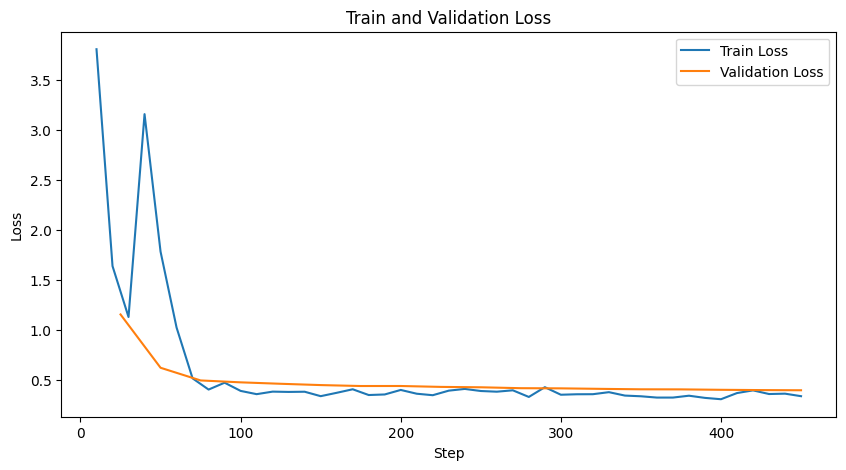

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

with open(losses_filename, 'r', encoding='utf-8') as fp:
    steps_losses = json.load(fp)

train_steps, train_losses = zip(*steps_losses[0])
eval_steps, eval_losses = zip(*steps_losses[1])

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
# plt.ylim(0, 1.4)
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


#### 2. 在“LoRA 低秩适配 OpenAI Whisper-Large-V2 语音识别任务”中，当 LoRA 模型训练完成后，使用测试集进行完整的模型评估。课程代码（ https://github.com/DjangoPeng/LLM-quickstart/blob/main/peft/peft_lora_whisper-large-v2.ipynb ）

In [3]:
from peft import PeftConfig, PeftModel
from transformers import AutoModelForSpeechSeq2Seq

peft_config = PeftConfig.from_pretrained(model_dir)

base_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    peft_config.base_model_name_or_path,
    load_in_8bit=True,
    device_map='auto'
)
base_model.requires_grad_(False)

/root/venvs/py311/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear8bitLt(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear8bitLt(in_fe

In [4]:
peft_model = PeftModel.from_pretrained(base_model, model_dir)
peft_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 1280)
          (layers): ModuleList(
            (0-31): 32 x WhisperEncoderLayer(
              (self_attn): WhisperSdpaAttention(
                (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=4, bias=False)
                  )
            

In [5]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = AutoProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
from datasets import load_dataset, DatasetDict, Audio

common_voice2 = DatasetDict()
common_voice2['test'] = load_dataset(dataset_name, language_abbr, split='test', trust_remote_code=True)
common_voice2 = common_voice2.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])
common_voice2 = common_voice2.cast_column('audio', Audio(sampling_rate=16000))
common_voice2

DatasetDict({
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 10581
    })
})

In [10]:
tokenized_common_voice2 = common_voice2.map(prepare_dataset)

In [11]:
import evaluate

metric = evaluate.load('wer')

In [14]:
from torch.utils.data import DataLoader

batch_size=30
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)
eval_dataloader = DataLoader(
    tokenized_common_voice2['test'], 
    batch_size=batch_size, 
    collate_fn=data_collator
)

In [15]:
from tqdm import tqdm
import gc
import numpy as np

for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                peft_model.generate(
                    input_features=batch['input_features'].to('cuda'),
                    decoder_input_ids=batch['labels'][:, :4].to('cuda'),
                    max_new_tokens=255,
                ).cpu().numpy()
            )
            labels = batch['labels'].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            metric.add_batch(predictions=decoded_preds, references=decoded_labels)
    
    del generated_tokens, labels, batch
    gc.collect()

wer = 100 * metric.compute()
print(f'{wer=:.3f}%')

with open('ch7.wer', 'w', encoding='utf-8') as fp:
    print(f'{wer=:.3f}%', file=fp)

  0%|          | 0/353 [00:00<?, ?it/s]/root/venvs/py311/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 353/353 [2:03:33<00:00, 21.00s/it]  


wer=65.28066528066529%


In [1]:
with open('ch7.wer', 'r', encoding='utf-8') as fp:
    print(fp.read())

wer=65.28066528066529%

